In [1]:

# Importación de librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder
from scipy.stats.mstats import winsorize
import xgboost as xgb
from xgboost import XGBRegressor
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

# Configuración para la visualización
%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)


## Data Loading

In [2]:

# Carga de los datos
data_path = '/Users/fernandopradagorge/Documents/Documentos - MacBook Pro de Fernando/Universidad/Master Data Science and AI/Nuclio Projects/Entregables/Entregable_3_Kaggle_31MAR24/ML_Time_Series/ts_kaggle_train.csv'  # Asegúrate de tener la ruta correcta al archivo
df = pd.read_csv(data_path)

# Visualización de las primeras filas del conjunto de datos
df.head()


,Unnamed: 0,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
0,0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0
1,1,2013-01-31,12_11369,16,12,9,11369,572.715278,30.0
2,2,2013-01-31,12_11370,16,12,9,11370,699.776786,30.0
3,3,2013-01-31,12_11373,16,12,9,11373,548.900000,6.0
4,4,2013-01-31,12_12231,16,12,49,12231,350.000000,3.0


In [3]:
# Información general del DataFrame
df.info()

# Estadísticas descriptivas
df.describe()

# Verificación de valores nulos
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14484 entries, 0 to 14483
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             14484 non-null  int64  
 1   date                   14484 non-null  object 
 2   unique_id              14484 non-null  object 
 3   city_id                14484 non-null  int64  
 4   shop_id                14484 non-null  int64  
 5   item_category_id       14484 non-null  int64  
 6   item_id                14484 non-null  int64  
 7   monthly_average_price  13262 non-null  float64
 8   monthly_sales          13756 non-null  float64
dtypes: float64(2), int64(5), object(2)
memory usage: 1018.5+ KB


Unnamed: 0                  0
date                        0
unique_id                   0
city_id                     0
shop_id                     0
item_category_id            0
item_id                     0
monthly_average_price    1222
monthly_sales             728
dtype: int64

In [52]:
# Convierto "unique_id" a str
df["unique_id"] = df["unique_id"].astype(str)

In [53]:
# Cambio la fecha a un formato adecuado para trabajar con ella
df["date"] = pd.to_datetime(df["date"], format= "%Y-%m-%d")

In [54]:
# Voy a comprobar cuantas series temporales tiene el dataset:
df["unique_id"].nunique()

426

In [55]:
# Ahora cuantos meses
len(df["date"].unique())

34

In [56]:
df.shape

(14141, 15)

In [57]:
# Una vez comprobados los demás elementos , voy a ver cuales son las fechas mínimas y máximas del dataset:
MIN_DATE = df["date"].min()
MAX_DATE = df["date"].max()

print(f"Min date is {MIN_DATE}\nMax date is {MAX_DATE}")

Min date is 2013-01-31 00:00:00
Max date is 2015-10-31 00:00:00


In [58]:
# Vuelvo a comprobar los nulos que tengo en el dataset
df.isnull().sum()

Unnamed: 0               0
date                     0
unique_id                0
city_id                  0
shop_id                  0
item_category_id         0
item_id                  0
monthly_average_price    0
monthly_sales            0
cluster                  0
month                    0
year                     0
sales_lag_1              0
sales_lag_2              0
sales_rolling_mean_3     0
dtype: int64

## Data Imputation

In [59]:
# Procedo a rellenar los valores NaN con 0
df.fillna({"monthly_sales":0}, inplace=True)

In [60]:
df["monthly_average_price"] = df.groupby("unique_id")["monthly_average_price"].transform(
    lambda x: x.ffill().bfill()
)

In [61]:
# Compruebo si he imputado los nulos correctamente
df.isnull().sum()

Unnamed: 0               0
date                     0
unique_id                0
city_id                  0
shop_id                  0
item_category_id         0
item_id                  0
monthly_average_price    0
monthly_sales            0
cluster                  0
month                    0
year                     0
sales_lag_1              0
sales_lag_2              0
sales_rolling_mean_3     0
dtype: int64

In [62]:
df.sort_values(["unique_id", "date"], ascending = True)

,Unnamed: 0,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,cluster,month,year,sales_lag_1,sales_lag_2,sales_rolling_mean_3
14,14,2013-03-31,0,16,12,9,11365,3252.470238,30.0,3,3,2013,27.0,30.0,21.666667
21,21,2013-04-30,0,16,12,9,11365,1590.515152,27.0,3,4,2013,30.0,27.0,25.000000
28,28,2013-05-31,0,16,12,9,11365,1447.531250,30.0,3,5,2013,27.0,30.0,20.333333
35,35,2013-06-30,0,16,12,9,11365,1302.343750,28.0,3,6,2013,30.0,27.0,23.000000
42,42,2013-07-31,0,16,12,9,11365,1736.785714,20.0,3,7,2013,28.0,30.0,15.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4208,4208,2015-06-30,99,7,25,64,16147,599.000000,1.0,0,6,2015,3.0,6.0,2.333333
4245,4245,2015-07-31,99,7,25,64,16147,599.000000,2.0,0,7,2015,1.0,3.0,2.000000
4282,4282,2015-08-31,99,7,25,64,16147,599.000000,5.0,0,8,2015,2.0,1.0,2.666667
4319,4319,2015-09-30,99,7,25,64,16147,599.000000,2.0,0,9,2015,5.0,2.0,4.666667


## EDA

In [63]:
def plot_ts_acf_pacf(y, title):
    fig = plt.figure(figsize=(12, 10))
    ax1, ax2, ax3 = fig.subplots(3, 1)

    ax1.plot(y)
    plot_acf(x = y, ax = ax2, lags = 14)
    plot_pacf(x = y, ax= ax3, lags = 14)

    plt.suptitle(t = title, fontsize = 20)

In [64]:
y = df.set_index("date").resample("ME")["monthly_sales"].sum()[:-1] # Con esta función elimino los registros de Octubre porque es lo que voy a predecir

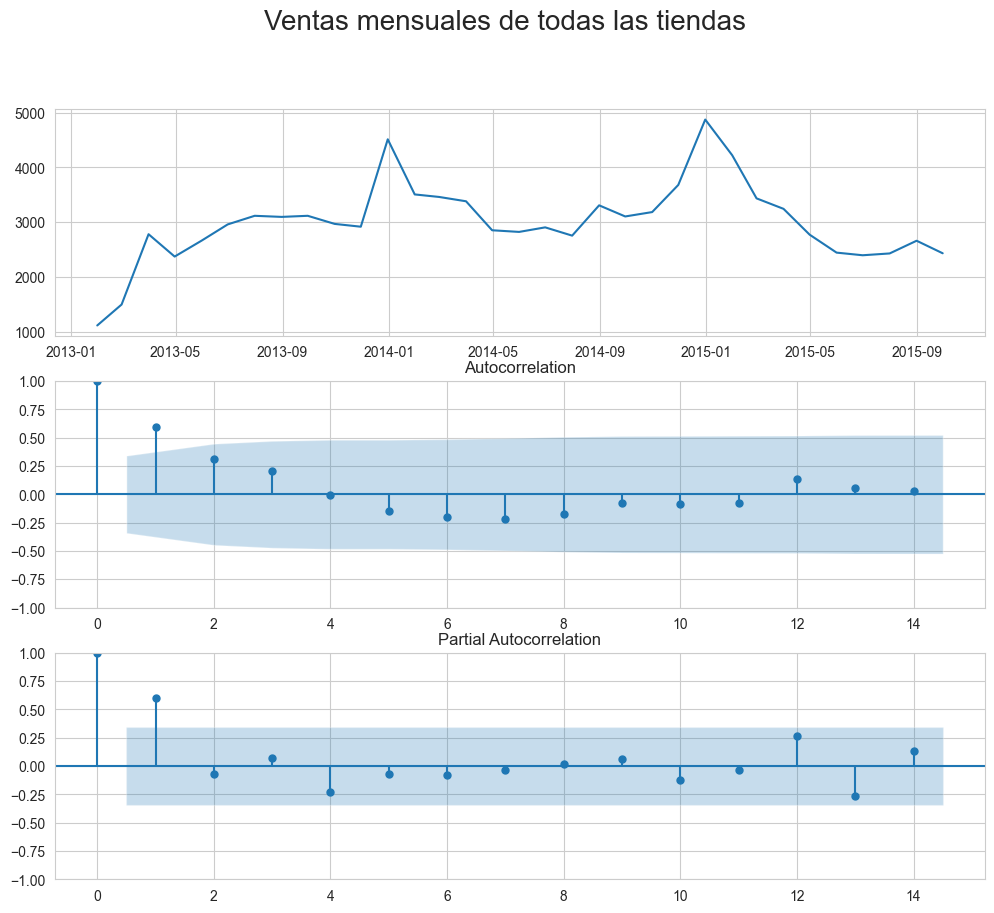

In [65]:
# Muestro una gráfica de las ventas mensuales de todas las tiendas
plot_ts_acf_pacf(y = y, title="Ventas mensuales de todas las tiendas")

## Clustering

In [66]:
# Voy a agrupar los datos en clusters para trabajar con ellos de forma mas sencilla.
# Extraigo las características con tsfresh
extracted_features = extract_features(df, column_id="unique_id", column_sort="date")

Feature Extraction:   0%|          | 0/10 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 10/10 [10:28<00:00, 62.84s/it]


In [18]:
# Ahora imputo los datos para manejar los NaN que se hayan podido introducir con tsfresh
imputed_features = impute(extracted_features)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['Unnamed: 0__fft_coefficient__attr_"real"__coeff_18'
 'Unnamed: 0__fft_coefficient__attr_"real"__coeff_19'
 'Unnamed: 0__fft_coefficient__attr_"real"__coeff_20' ...
 'monthly_sales__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'monthly_sales__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'monthly_sales__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


In [19]:
# Ahora estandarizo las características
impute(extracted_features)
features_scaled = StandardScaler().fit_transform(imputed_features)

## Aplico K-Means

In [67]:
# Defino los números de clusters
n_clusters = 5

# Aplico K-Means
kmeans = KMeans(n_clusters = n_clusters, random_state=0)
clusters = kmeans.fit_predict(features_scaled)

# Asigno los clusters al DataFrame original
unique_ids = df["unique_id"].unique()
clusters_df = pd.DataFrame({"unique_id": unique_ids, "cluster": clusters})

# Ahora ahgo un merge de todo
df = df.merge(clusters_df, on="unique_id", how="left")

In [68]:
df = df.merge(clusters_df, on="unique_id", how="left", suffixes=('', '_y'))
df.drop(df.filter(regex='_y$').columns.tolist(), axis=1, inplace=True)

In [69]:
if 'cluster' in df.columns:
    df.drop('cluster', axis=1, inplace=True)
df = df.merge(clusters_df, on="unique_id", how="left")

In [23]:
#df = df.rename(columns={"unique_id": "id"})

In [70]:
df.head()

,Unnamed: 0,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,cluster_x,month,year,sales_lag_1,sales_lag_2,sales_rolling_mean_3,cluster
0,14,2013-03-31,0,16,12,9,11365,3252.470238,30.0,3,3,2013,27.0,30.0,21.666667,3
1,15,2013-03-31,1,16,12,9,11369,683.331502,30.0,3,3,2013,30.0,30.0,25.333333,3
2,16,2013-03-31,2,16,12,9,11370,1190.350529,30.0,3,3,2013,30.0,30.0,29.000000,3
3,17,2013-03-31,3,16,12,9,11373,195.333333,21.0,3,3,2013,2.0,6.0,20.666667,3
4,18,2013-03-31,4,16,12,49,12231,350.000000,5.0,2,3,2013,2.0,3.0,11.333333,2


## Analizo los clusters

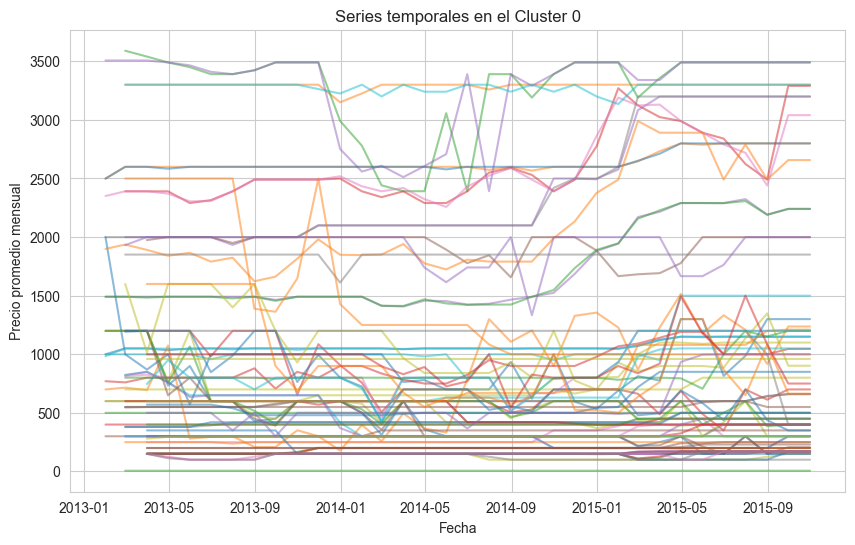

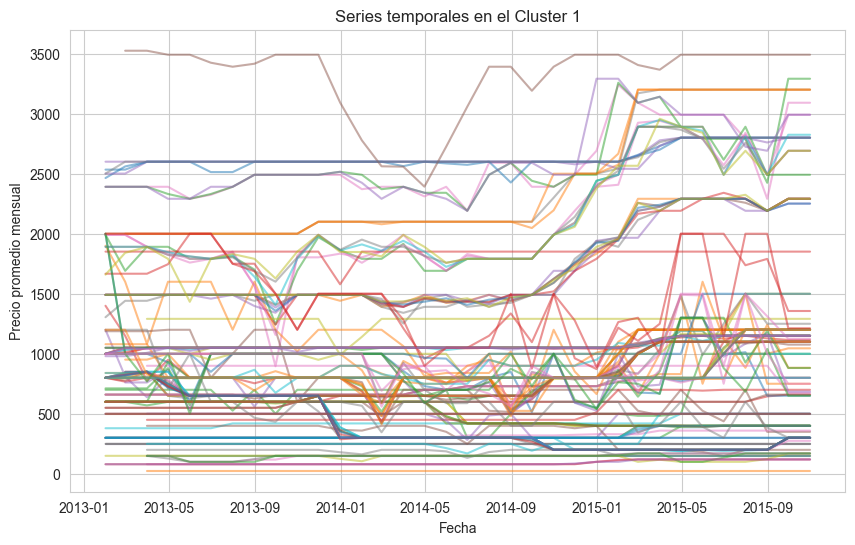

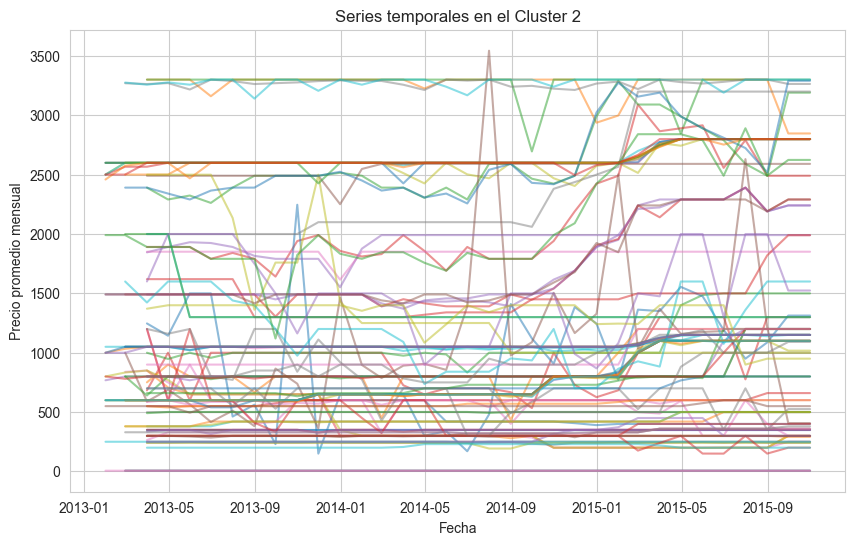

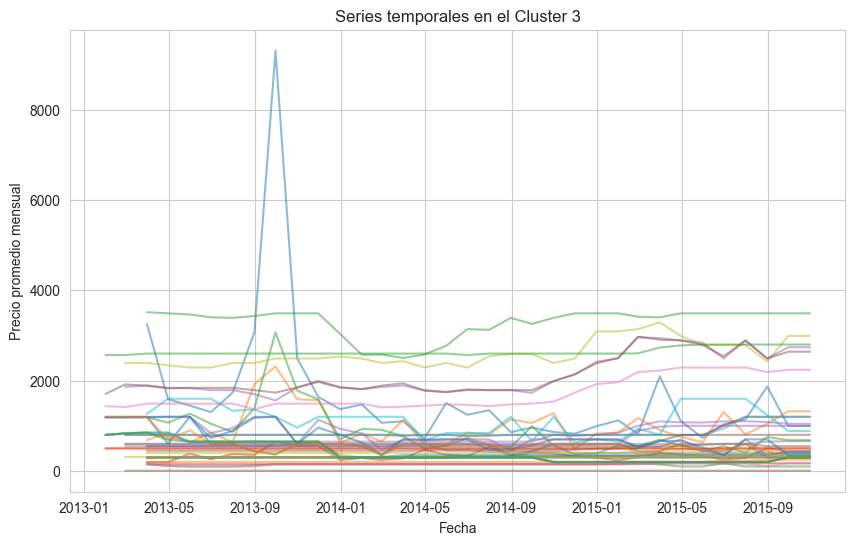

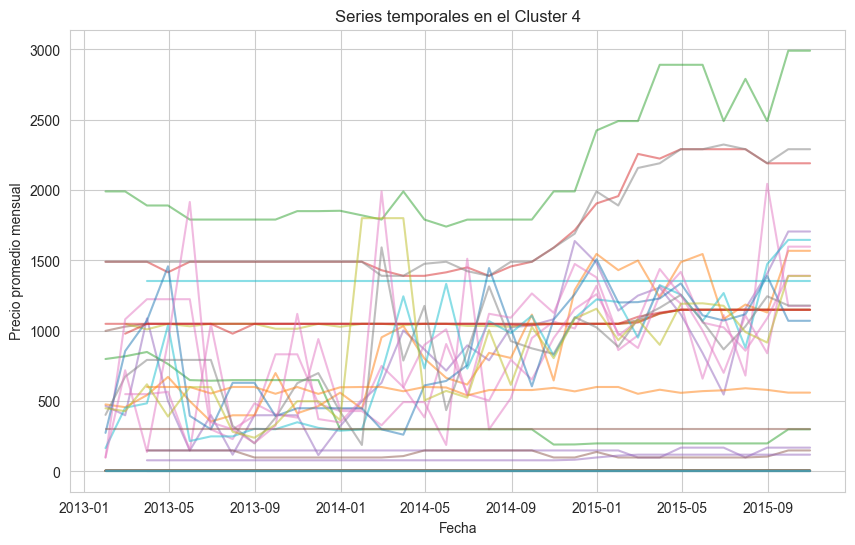

In [71]:
# Visualizo las series temporales en cada cluster
for cluster in range(n_clusters):
    plt.figure(figsize=(10, 6))
    
    # Selecciona solo las filas que pertenecen al cluster actual
    cluster_df = df[df["cluster"] == cluster]
    
    # Asegúrate de que hay datos en el cluster antes de intentar graficar
    if cluster_df.empty:
        print(f"El Cluster {cluster} está vacío.")
        continue
    
    # Grafica cada serie temporal individual en el cluster
    for unique_id in cluster_df["unique_id"].unique():
        unique_id_series = cluster_df[cluster_df["unique_id"] == unique_id]
        plt.plot(unique_id_series["date"], unique_id_series["monthly_average_price"], alpha=0.5)
    
    plt.title(f"Series temporales en el Cluster {cluster}")
    plt.xlabel("Fecha")
    plt.ylabel("Precio promedio mensual")
    plt.show()


In [72]:
df.head()

,Unnamed: 0,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,cluster_x,month,year,sales_lag_1,sales_lag_2,sales_rolling_mean_3,cluster
0,14,2013-03-31,0,16,12,9,11365,3252.470238,30.0,3,3,2013,27.0,30.0,21.666667,3
1,15,2013-03-31,1,16,12,9,11369,683.331502,30.0,3,3,2013,30.0,30.0,25.333333,3
2,16,2013-03-31,2,16,12,9,11370,1190.350529,30.0,3,3,2013,30.0,30.0,29.000000,3
3,17,2013-03-31,3,16,12,9,11373,195.333333,21.0,3,3,2013,2.0,6.0,20.666667,3
4,18,2013-03-31,4,16,12,49,12231,350.000000,5.0,2,3,2013,2.0,3.0,11.333333,2


## Preparación de los datos después del clustering

In [73]:
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# Creo lags
df['sales_lag_1'] = df.groupby('item_id')['monthly_sales'].shift(1)
df['sales_lag_2'] = df.groupby('item_id')['monthly_sales'].shift(2)

# Creo medias móviles
df['sales_rolling_mean_3'] = df.groupby('item_id')['monthly_sales'].shift(1).rolling(window=3).mean()

# Después de crear estas nuevas características, elimino las filas con NaN resultantes de los lags y las medias móviles
df.dropna(inplace=True)

# Definiendo el conjunto de características
features = ['cluster', 'monthly_average_price', 'month', 'year', 'sales_lag_1', 'sales_lag_2', 'sales_rolling_mean_3']


In [74]:
X = df[features]
y = df['monthly_sales']

In [75]:
# Divido el conjunto de datos de esta manera para mantener la secuencia temporal.
# En series temporales, es crucial respetar el orden temporal para evitar el "leakage" de información futura en el conjunto de entrenamiento. En lugar de usar una división aleatoria, uso una división en función del tiempo. Esto significa que los datos más antiguos se utilizarán para el entrenamiento y los más recientes para la prueba.
split_point = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

## Entrenamiento del modelo

In [76]:
# Ordeno las fechas únicas y las asigno a los conjuntos de índices
fechas_unicas = sorted(list(df["date"].unique()))

# Las fechas para el conjunto de entrenamiento son todas excepto las últimas dos
train_index = fechas_unicas[:-2]

# La penúltima fecha única es para el conjunto de validación
valida_index = [fechas_unicas[-2]]

# La última fecha única es para el conjunto de prueba
test_index = [fechas_unicas[-1]]

In [77]:
df['unique_id'] = pd.Categorical(df['unique_id'])
df['unique_id'] = df['unique_id'].cat.codes

X_train = df[df["date"].isin(train_index)].drop(['monthly_sales', "date"], axis=1)
y_train = df[df["date"].isin(train_index)]['monthly_sales']

X_valida = df[df["date"].isin(valida_index)].drop(['monthly_sales', "date"], axis=1)
y_valida = df[df["date"].isin(valida_index)]['monthly_sales']

X_test = df[df["date"].isin(test_index)].drop(['monthly_sales', "date"], axis = 1)
y_test = df[df["date"].isin(test_index)]['monthly_sales']

# Inicializo y entreno el modelo XGBoost
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',  # Utilizo el error cuadrático para problemas de regresión
    n_estimators=1000, # Aumenta el número de árboles, pero la parada temprana detendrá el entrenamiento si no hay mejora
    learning_rate=0.05,
    max_depth=5, # Profundidad máxima de los árboles
    subsample=0.8,  # Fracción de muestras a utilizar para cada árbol - previene el sobreajuste
    colsample_bytree=0.8, # Fracción de características a utilizar para cada árbol
    random_state=42,
    eval_metric=["rmse", "mae"],  
    early_stopping_rounds=50
)

eval_set = [(X_train, y_train), (X_test, y_test)]

xgb_model.fit(
    X_train, y_train, 
    eval_set=eval_set, 
    verbose=True
)

# Predicciones
y_pred = xgb_model.predict(X_test)

# Evaluación del modelo
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")


[0]	validation_0-rmse:7.66666	validation_0-mae:5.51273	validation_1-rmse:7.23555	validation_1-mae:7.22862


[1]	validation_0-rmse:7.40309	validation_0-mae:5.33730	validation_1-rmse:7.20557	validation_1-mae:7.17840
[2]	validation_0-rmse:7.16024	validation_0-mae:5.18151	validation_1-rmse:7.19468	validation_1-mae:7.13586
[3]	validation_0-rmse:6.92834	validation_0-mae:5.03005	validation_1-rmse:7.18409	validation_1-mae:7.08462
[4]	validation_0-rmse:6.71096	validation_0-mae:4.88602	validation_1-rmse:7.18664	validation_1-mae:7.03844
[5]	validation_0-rmse:6.52091	validation_0-mae:4.76097	validation_1-rmse:7.20468	validation_1-mae:7.00419
[6]	validation_0-rmse:6.33079	validation_0-mae:4.63192	validation_1-rmse:7.21972	validation_1-mae:6.95876
[7]	validation_0-rmse:6.16072	validation_0-mae:4.51915	validation_1-rmse:7.26888	validation_1-mae:6.94356
[8]	validation_0-rmse:5.99602	validation_0-mae:4.40778	validation_1-rmse:7.30597	validation_1-mae:6.90998
[9]	validation_0-rmse:5.83833	validation_0-mae:4.30114	validation_1-rmse:7.34193	validation_1-mae:6.87180
[10]	validation_0-rmse:5.69183	validation_0-ma

## Entrenamiento del Modelo

In [78]:
# Uso gridsearch para encontrar los mejores parámetros
model_base = xgb.XGBRegressor(eval_metric="rmse", seed=175, eta=0.1)
# Defino los parámetros a ajustar
param_grid = {
    'n_estimators': [300, 500, 700],
    'max_depth': [4, 6, 7],
    'learning_rate': [0.05, 0.1, 0.2]

}
grid_search = GridSearchCV(estimator=model_base, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error')

In [79]:
grid_search.fit(X_train, y_train, verbose=True)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eta=0.1,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_r...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [4, 6, 7],
                         'n_estimators': [300, 500, 700]},
             scoring='neg_root_mean_squared_error')

In [80]:
print("Mejores parámetros:", grid_search.best_params_)
best_model = grid_search.best_estimator_
print("Mejor puntaje encontrado:")
print(grid_search.best_score_)

Mejores parámetros: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 300}
Mejor puntaje encontrado:
-4.194251152627549


In [81]:
best_model=xgb.XGBRegressor(eval_metric="rmse", seed=74, eta=0.05, max_depth=4, n_estimators=300, gamma=0.1, alpha=0.1, min_child_weight=1)
best_model

XGBRegressor(alpha=0.1, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.05, eval_metric='rmse',
             feature_types=None, gamma=0.1, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, ...)

In [82]:
best_model.fit( X_train, y_train,
    eval_set = [(X_train, y_train), (X_valida, y_valida)],
    verbose = True,
    early_stopping_rounds = 15)

[0]	validation_0-rmse:7.67262	validation_1-rmse:7.26096
[1]	validation_0-rmse:7.41594	validation_1-rmse:6.99280


[2]	validation_0-rmse:7.17472	validation_1-rmse:6.73530
[3]	validation_0-rmse:6.95051	validation_1-rmse:6.50032
[4]	validation_0-rmse:6.74008	validation_1-rmse:6.27425
[5]	validation_0-rmse:6.54355	validation_1-rmse:6.05810
[6]	validation_0-rmse:6.36020	validation_1-rmse:5.86270
[7]	validation_0-rmse:6.18977	validation_1-rmse:5.67131


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-rmse:6.03098	validation_1-rmse:5.49950
[9]	validation_0-rmse:5.88244	validation_1-rmse:5.33153
[10]	validation_0-rmse:5.74446	validation_1-rmse:5.17738
[11]	validation_0-rmse:5.61666	validation_1-rmse:5.03616
[12]	validation_0-rmse:5.49826	validation_1-rmse:4.90183
[13]	validation_0-rmse:5.38821	validation_1-rmse:4.77798
[14]	validation_0-rmse:5.28647	validation_1-rmse:4.66244
[15]	validation_0-rmse:5.19226	validation_1-rmse:4.55336
[16]	validation_0-rmse:5.10501	validation_1-rmse:4.45075
[17]	validation_0-rmse:5.02378	validation_1-rmse:4.35494
[18]	validation_0-rmse:4.94838	validation_1-rmse:4.26387
[19]	validation_0-rmse:4.87897	validation_1-rmse:4.18945
[20]	validation_0-rmse:4.81494	validation_1-rmse:4.11945
[21]	validation_0-rmse:4.75609	validation_1-rmse:4.05208
[22]	validation_0-rmse:4.69986	validation_1-rmse:3.98571
[23]	validation_0-rmse:4.64942	validation_1-rmse:3.92492
[24]	validation_0-rmse:4.60226	validation_1-rmse:3.87684
[25]	validation_0-rmse:4.55836	va

XGBRegressor(alpha=0.1, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.05, eval_metric='rmse',
             feature_types=None, gamma=0.1, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, ...)

In [84]:
predictions = best_model.predict(X_test)

In [85]:
# Defino el espacio de búsqueda de parámetros
param_dist = {
    'n_estimators': stats.randint(100, 1000),
    'max_depth': stats.randint(3, 8),
    'learning_rate': stats.uniform(0.05, 0.15)
}

# Inicio el RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model_base, param_distributions=param_dist, n_iter=10, cv=3, scoring='neg_root_mean_squared_error', random_state=42)

# Entreno el modelo con RandomizedSearchCV
random_search.fit(X_train, y_train)

# Muestro los mejores parámetros encontrados
print("Mejores parámetros:", random_search.best_params_)

# Obtengo el mejor modelo
best_model_random = random_search.best_estimator_

# Hago predicciones con el mejor modelo
predictions_random = best_model_random.predict(X_test)

Mejores parámetros: {'learning_rate': 0.14262222644415748, 'max_depth': 4, 'n_estimators': 121}


In [86]:
# Defino el espacio de búsqueda de parámetros
param_dist = {
    'n_estimators': Integer(100, 1000),
    'max_depth': Integer(3, 8),
    'learning_rate': Real(0.05, 0.2, 'uniform')
}

# Inicio el BayesSearchCV
bayes_search = BayesSearchCV(estimator=model_base, search_spaces=param_dist, n_iter=10, cv=3, scoring='neg_root_mean_squared_error', random_state=42)

# Entreno el modelo con BayesSearchCV
bayes_search.fit(X_train, y_train)

# Muestro los mejores parámetros encontrados
print("Mejores parámetros:", bayes_search.best_params_)

# Obtengo el mejor modelo
best_model_bayes = bayes_search.best_estimator_

# Hago predicciones con el mejor modelo
predictions_bayes = best_model_bayes.predict(X_test)

Mejores parámetros: OrderedDict({'learning_rate': 0.11672487684517278, 'max_depth': 8, 'n_estimators': 194})


In [87]:
model = xgb.XGBRegressor(eval_metric = "rmse", seed = 175, eta=0.1)

model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_valida, y_valida)], verbose = True)

[0]	validation_0-rmse:7.37401	validation_1-rmse:6.95751


[1]	validation_0-rmse:6.87153	validation_1-rmse:6.42994
[2]	validation_0-rmse:6.43411	validation_1-rmse:5.97953
[3]	validation_0-rmse:6.05226	validation_1-rmse:5.58155
[4]	validation_0-rmse:5.71716	validation_1-rmse:5.21786
[5]	validation_0-rmse:5.42566	validation_1-rmse:4.90959
[6]	validation_0-rmse:5.17594	validation_1-rmse:4.63894
[7]	validation_0-rmse:4.95806	validation_1-rmse:4.40691
[8]	validation_0-rmse:4.77495	validation_1-rmse:4.22214
[9]	validation_0-rmse:4.61676	validation_1-rmse:4.04204
[10]	validation_0-rmse:4.47886	validation_1-rmse:3.90662
[11]	validation_0-rmse:4.36424	validation_1-rmse:3.77458
[12]	validation_0-rmse:4.26376	validation_1-rmse:3.67407
[13]	validation_0-rmse:4.17393	validation_1-rmse:3.57879
[14]	validation_0-rmse:4.09787	validation_1-rmse:3.50498
[15]	validation_0-rmse:4.02679	validation_1-rmse:3.44053
[16]	validation_0-rmse:3.96876	validation_1-rmse:3.39076
[17]	validation_0-rmse:3.91822	validation_1-rmse:3.33769
[18]	validation_0-rmse:3.87319	validatio

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric='rmse',
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

## Evaluación del Modelo

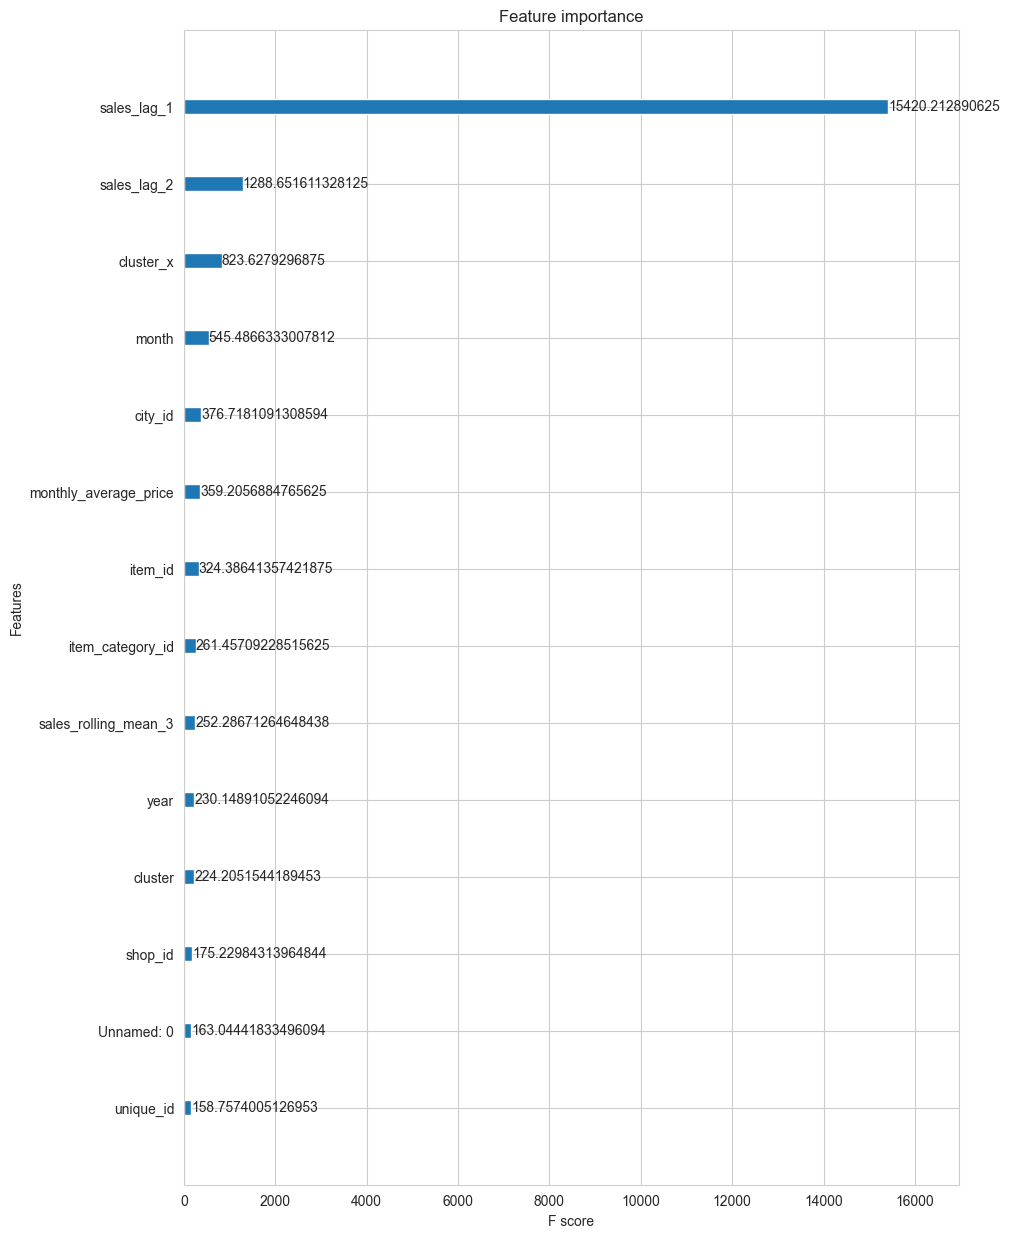

In [88]:
fig, ax = plt.subplots(figsize = (10, 15))
xgb.plot_importance(best_model, importance_type = "gain", ax = ax);

## Predicción

In [90]:
if "monthly_sales" in X_test.columns:
    X_test.drop("monthly_sales", axis = 1, inplace = True)

y_test_predict = best_model.predict(X_test)
X_test["monthly_sales"] = y_test_predict

In [91]:
X_test.reset_index(inplace = True)

In [92]:
y_train_predict = best_model.predict(X_train)
y_valida_predict = best_model.predict(X_valida)

rmse_train = np.sqrt(
    mean_squared_error(
        y_true = y_train,
        y_pred = y_train_predict
    )
)

rmse_valida = np.sqrt(
    mean_squared_error(
        y_true = y_valida,
        y_pred = y_valida_predict
    )
)

rmse_train= str(round(rmse_train, 3)).replace(".", "_")
rmse_valida = str(round(rmse_valida, 3)).replace(".", "_")

In [93]:
print(f"Train RMSE: {rmse_train}")
print(f"Validation RMSE: {rmse_valida}")

Train RMSE: 3_613
Validation RMSE: 2_995


In [94]:
ruta_guardado = "/Users/fernandopradagorge/Documents/Documentos - MacBook Pro de Fernando/Universidad/Master Data Science and AI/Nuclio Projects/Entregables/Entregable_3_Kaggle_31MAR24"

X_test[["unique_id", "monthly_sales"]].to_csv(
    f"{ruta_guardado}submission_train_{rmse_train}_valida_{rmse_valida}.csv",
    index=False
)